# Chapter 2: Robust Estimates for the Covariance Matrix


## Key Concepts
- Understand constant correlation covariance matrix estimate
- Factor-based covariance matrix estimate
- Statistical shrinkage covariance matrix estimate
- ARCH & GARCH models

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import edhec_risk_kit_206 as erk

%load_ext autoreload
%autoreload 2
%matplotlib inline

# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-pastel") 

## 1. Estimates for the covariance matrix

**Modern Portfolio Theory (MPT)** is futile if the portfolio is constructed based on naive estimates of the input parameters, as they often lead to non-sensible portfolio allocations.

The optimal allocation was based on **past** returns and covariances is not reliable.

Here, we focus on bridging the gap between portfolio theory and portfolio construction by showing **how to generate enhanced parameter estimates** so as to improve the quality of the portfolio optimization outputs (optimal portfolio weights), with a focus on risk parameter estimates. 

We address **sample risk and explain how to improve covariance matrix estimation** via the use of **factor and/or Bayesian techniques** and **statistical shrinkage estimators**.

### 1.1. Curse of dimensionality in estimating the covariance matrix

Suppose we want to build a portfolio of $N$ stocks (of which we have available data). 
We then should **estimate**: 
- $N$ returns (expected returns), 
- $N$ volatilities, and 
- $N(N-1)/2$ covariances (correlation coefficients), as the covariance matrix contains $N$ entries, from which we remove the diagonal consisting of $N$ variances, and then, since it is symmetric, we divide by the remaining total number of entries). 

As $N$ grows, it may be a problem to have such a large number of parameters to estimate. In the presence of large portfolios, **the number of parameters if often larger than the sample size**

### 1.2. Parameter estimations: $\Sigma$

Recall that, given $N$ assets, we denote by $\Sigma$ be the $N\times N$ symmetric square 
covariance matrix, $\Sigma = [c_{ij}]$, 
where each element $c_{ij} := \rho_{ij} \sigma_i \sigma_j$ ($i,j=1,\dots,N$) 
denote the **covariance** between (the returns of) assets $i$ and asset $j$, 
with $\sigma_i$, $\sigma_j$, and $\rho_{ij}$ being the volatility 
and the correlation coefficient of assets $i$ and $j$, respectively. 
If $i=j$, $c_{ii}=\sigma_i^2$ is simply the variance of asset $i$ (**diagonal entries are the variances**). 
The volatility of the portfolio is then given 
by $\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }$.

#### 1. Sample Covariance Matrix: No model risk - high sample risk

The simplest **covariance estimator** is the **sample covariance matrix** $\Sigma = [c_{ij}]$. No model risk (we are just applying the definition) but highly sensitive to the data sample. Also, we are going to estimate $N(N+1)/2$ parameters.

#### 2. Constant Correlation Model: High model risk - low sample risk

**Constant correlation model** assumes a constant correlation coefficient $\rho$ for all assets. 

That is, we define the entries of our covariane matrix as 
$$
c_{ij} := \hat{\rho}\, \sigma_i \sigma_j.
\qquad i,j=1,\dots,N,
$$

$$
\hat{\rho} := \frac{1}{N(N-1)} \sum_{i\neq j}^N \rho_{ij},
$$
Notice that in computing $\hat{\rho}$ we should compute all $\rho_{ij}$

#### 3. Using a factor model: Relative Low model risk, Relative High Sample Risk


In general, **multi-factor models** state that the excessive return of any asset $i$ 
over the risk-free rate satisfies:
$$
r_i^e = r_{i,t} - r_{f,t}  = \beta_1^i f_1 +\dots +\beta_K^i f_K + \varepsilon_{i,t}, 
$$

If a few factors can completely capture the cross-sectional risks, 
the number of parameters in covariance matrix estimation can be significantly reduced. 

An example using $2$ factors is the following. The model is given by:
$$
r_i^e := r_i - r_f =  \beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i
\quad \forall\;i=1,\dots,N.
$$
Now, the variance are given by, for all $i$: 
$$
\sigma_{ii} = \text{Var}\left(\beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i\right) 
= (\beta_1^i)^2 \sigma_{f_1}^2 + (\beta_2^i)^2 \sigma_{f_2}^2 + 2\beta_1^i \beta_2^i\text{Cov}(f_1,f_2) + \sigma_{\varepsilon_i}^2, 
$$
assuming $\text{Cov}(f_i,\epsilon_j) = 0$


The covariances are then:
$$
c_{ij} = \text{Cov}\left(r_i^e,r_j^e\right) 
= \text{Cov}\left(\beta_1^i f_1 + \beta_2^i f_2 + \varepsilon_i, \beta_1^j f_1 + \beta_2^j f_2 + \varepsilon_j\right)
= \beta_1^i \beta_1^j \sigma_{f_1}^2 
+ \beta_2^i \beta_2^j \sigma_{f_2}^2 
+ \left(\beta_1^i \beta_2^j + \beta_2^i \beta_1^j\right) \text{Cov}(f_1,f_2) + \text{Cov}(\varepsilon_i,\varepsilon_j).
$$

Then we further make two assumptions:

1. $\text{Cov}(f_1,f_2)=0$ 
2. $\text{Cov}(\varepsilon_i,\varepsilon_j)=0$. 

The total number of parameters to estimate in the covariance matrix are: 
- $N$ coefficients $\beta_1$
- $N$ coefficients $\beta_2$
- The 2 volatilities of factors $\sigma_{f_1}$, $\sigma_{f_2}$

i.e., a total of $2(N+1)$ numbers.

Factors that could be used are:
- **explicit macro factors**, e.g. inflation growth, interest rate
- **explicit micro factors**, e.g. characteristic of different stocks like country, size, B/P ratios
- **implicit (statistical) factors** 

Using a factor model is a convenient way to **reduce the number of risk parameters** that have to be estimated. However, it introduces, of course, a reasonable amount of **model risk**.
Also, **implicit factor model** is usually preferred since it lets the data tell us what the relevant factors are, thus alleviating the model risk.

#### 4. Statistical Shrinkage
**Statistical Shrinkage** allow one to find the optimal trade-off between **sample risk** and **model risk**. 

The idea is based on the **average of two covariance matrix estimates**, one with **high sample risk** and one with 
**high model risk**:
$$
E_{shrink} := \delta \hat{F} + (1-\delta)\hat{S}
$$
where $\hat{F}$ is the **factor-model based estimator** of the covariance matrix, $\hat{S}$ which is instead an estimator of the covariance matrix which is not factor-model based, and $\delta$ is the shrinkage factor (in $(0,1)$). 


## 2. Time-Varying Risk parameters

The first thing to notice before making any kind of analysis is that the **volatility is not constant** over time. That is, when we have to estimate volatility, we should take into account the fact that this is something that vary in time, hence our estimation should be varying as well.

For example, let us pick the total index market returns:

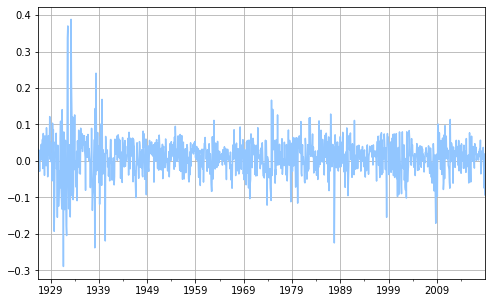

In [12]:
tot_mkt_rets = erk.get_total_market_index_returns()
tot_mkt_rets.plot(grid=True, figsize=(8,5))
plt.show()

The annualized volatility over the entire period is:

In [13]:
ann_vol_constant = erk.annualize_vol(tot_mkt_rets, periods_per_year=12)
ann_vol_constant

0.18360776591130698

However, let us using a rolling window and let us compute the timeseries of annualized volatilities:

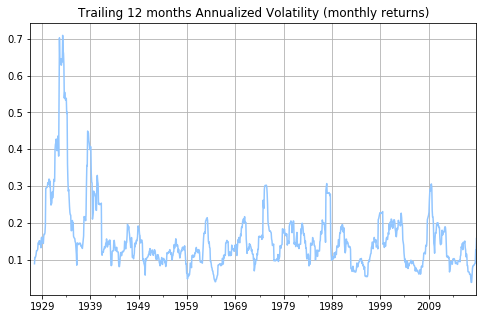

In [14]:
# pick yearly data (i.e., 12 monthly data)
window = 12
ann_vol_tv = tot_mkt_rets.rolling(window = 1*window).std() * np.sqrt(window)
ann_vol_tv.plot(grid=True, figsize=(8,5), title="Trailing 12 months Annualized Volatility (monthly returns)")
plt.show()

We see that the mean volatility of this timie-varying series is given by:

In [15]:
ann_vol_tv.mean()

0.15770732194601642

which is different from the "static" variance we have used over the entire period. 

#### Volatility cone 
Note that in the computation above, the volatility timeseries changes when windows changes. In particular, we can plot the so-called **volatility cone** which plot the minimum and the maximum of the volatility timeseries when the window changes.

Below the change the window by years:

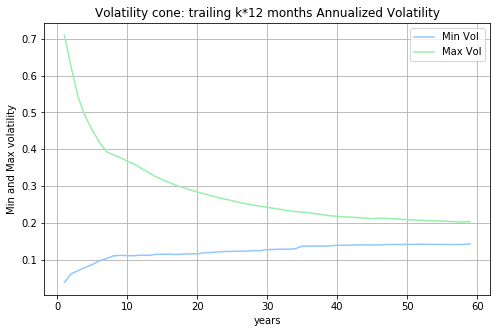

In [16]:
# pick yearly data (i.e., 12 monthly data)
window = 12
years  = np.arange(1,60,1)

mm_vol = []
for k in years:
    ann_vol_tv = tot_mkt_rets.rolling(window = k*window).std() * np.sqrt(window)
    mm_vol.append( [ann_vol_tv.min(), ann_vol_tv.max()] )

vol_cone = pd.DataFrame(mm_vol, index=years, columns=["Min Vol", "Max Vol"])

ax = vol_cone.plot(grid=True, figsize=(8,5), title="Volatility cone: trailing k*12 months Annualized Volatility")
ax.set_xlabel("years")
ax.set_ylabel("Min and Max volatility")
plt.show()

We can see that as soon as the window increase the cone shrinks, in particular the recorded maximum volatility decreases.

The assumption that the variance of a series of return may be uniform (constant) is known as **homoskedasticity**. When this is not the case (almost always) we talk about **heteroskedasticity**. 
Morevoer, the fact that the variance is not uniform and it is affected by previous variances 
is referred to as **autoregression** (in statistics we talk about **conditional** variance).

We have to compute the volatility in a way that takes into account variations over time. 

#### 1. Exponentially Weigthed (Moving) Average (EWMA)

Let us define the squared error returns by $\epsilon_n^2 := (r_n - \mu)^2$, where $\mu:=\frac{1}{N}\sum_{i=1}^N r_n$ is the mean return over the entire timeseries.

EWMA assign **"more weight"** to the **most recent** observations and "lower weights" to the oldest observations where weights assigned **decline exponentially**. 

We define the weigths as:
$$
\sigma^2_{N,EWA} = \sum_{n=1}^N \alpha_n \epsilon_n^2
\quad\text{where}\quad
\alpha_n = \frac{ \lambda^{N-n} }{\sum_{n=1}^N \lambda^{N-n} } \;\; \forall\; n, 
$$
where $\lambda^{T-n} \in (0,1]$ is the **decay (or smoothing) factor**. For example, **RiskMetrics** (a financial risk management company) tends to use a decay factor of $\lambda=0.94$.

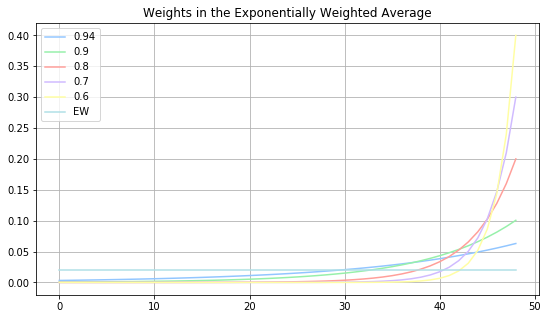

In [17]:
# Example:
T = 50
points = np.arange(1,T,1)
decay_factor = [0.94, 0.9, 0.8, 0.7, 0.6]

ww = []
for d in decay_factor:
    ww.append( [ d**(T-t) for t in points ] / np.sum( d**(T-points) ) )

weigths = pd.DataFrame(ww, index=decay_factor).T
weigths["EW"] = 1/T
weigths.plot(grid=True, figsize=(9,5), title="Weights in the Exponentially Weighted Average")
plt.show()

Let us see how volatilities changes using the EWA (using the **annualize_vol_ewa** method in the kit):

In [19]:
def annualize_vol_ewa(r, decay=0.95, periods_per_year=12):
    '''
    Computes the annualized exponentially weighted average volatility of a 
    series of returns given a decay (smoothing) factor in input. 
    '''
    N = r.shape[0]
    times = np.arange(0,N,1)
    # compute the square error returns
    sq_errs = pd.DataFrame( ( r - r.mean() )**2 )
    # exponential weights
    weights = [ decay**(N-t) for t in times ] / np.sum(decay**(N-times))
    weights = pd.DataFrame(weights, index=r.index)
    # EWA
    vol_ewa = (weights * sq_errs).sum()**(0.5)
    # Annualize the computed volatility
    ann_vol_ewa = vol_ewa[0] * np.sqrt(periods_per_year)
    return ann_vol_ewa

In [31]:
tot_mkt_rets = erk.get_total_market_index_returns()
ann_vol_constant = erk.annualize_vol(tot_mkt_rets, periods_per_year=12)

print("Standard volatility : {:.2f}%" .format(ann_vol_constant*100))
print("Exponentially Weigth:")

decays = [1, 0.99, 0.98, 0.97, 0.95, 0.93, 0.85, 0.837, 0.6,0.5, 0.4, 0.3, 0.1]
for d in decays:
    ann_vol_ewa = annualize_vol_ewa(tot_mkt_rets, decay=d, periods_per_year=12)
    print("         decay={:.3f}: {:.2f}%" .format(d, ann_vol_ewa*100))

Standard volatility : 18.36%
Exponentially Weigth:
         decay=1.000: 18.35%
         decay=0.990: 13.84%
         decay=0.980: 12.89%
         decay=0.970: 12.58%
         decay=0.950: 13.06%
         decay=0.930: 14.03%
         decay=0.850: 17.83%
         decay=0.837: 18.36%
         decay=0.600: 25.21%
         decay=0.500: 27.21%
         decay=0.400: 28.96%
         decay=0.300: 30.57%
         decay=0.100: 33.74%


In fact, EWA can be viewed as a special ARIMA(0,1,1) model (Tsay, 2012)

#### 2. Auto-regressive Conditional Heteroscedasticity (ARCH) model 

The **autoregressive conditional heteroscedasticity (ARCH)** model is a variation around the same methodology of the exponential weigthed average idea in which the variance is supposed to be time-varying and dependent on some previous variances. 

In this model, the difference is that we use a kind of **long-term variance estimate** as an anchor point. 
Let us call by $V_L$ the very "long-term estimator for the variance" that can be given, **for example, by the volatility or the variance estimate over the last 50, 20 years**. 

We write ARCH($p$) to say that we use define current (today's) variance 
as a function of last previous $p$ squared error returns: 
$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega} 
+ \sum_{n=1}^p \alpha_{N-n} \epsilon_{N-n}^2
\quad \text{where} \quad
\gamma + \sum_{n=1}^p \alpha_n = 1.
$$
If $p=N$ then we use the entire timeseries of returns of $N$ points. 

If $p=1$, we use only the last previous squared error return:
$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega} 
+ \alpha_{N-1} \epsilon_{N-1}^2
\quad \text{where} \quad
\gamma + \alpha_{N-1} = 1.
$$


#### 3. Generalized Auto-regressive Conditional Heteroscedasticity (GARCH) model 

The **Generalized Auto-regressive Conditional Heteroscedasticity (GARCH)** model is an improvement over the ARCH model that is going to have also a weighted average of the last, previous, estimate of variance.

We call GARCH($p,q$) the model:
$$
\sigma_{N}^2 
= \underbrace{ \gamma V_L }_{=:\omega} 
+ \sum_{n=1}^p \alpha_{N-n} \epsilon_{N-n}^2
+ \sum_{m=1}^q \beta_{N-m} \sigma_{N-m}^2
\quad \text{where} \quad
\gamma + \sum_{n=1}^p \alpha_{N-n} + \sum_{m=1}^q \beta_{N-m} = 1,
$$

For $p=q=1$ we have the simplest GARCH(1,1) model:
$$
\sigma_{N}^2 = \gamma V_L + \alpha_{N-1} \epsilon_{N-1}^2 + \beta_{N-1} \sigma^2_{N-1}
\quad \text{where} \quad
\gamma + \alpha_{N-1} + \beta_{N-1} = 1,
$$

Note that when using a GARCH (or ARCH) model we are indeed increasing the number of parameters to estimate, as for each asset's volatility we have about $p+q$ parameters to estimate. 
If we are looking at a fairly large number of assets, and we are concerned that volatility is time-varying, there are parsimonious ways to use GARCH model known as **Factor GARCH**, 
in which instead of using $q$ past variances in the GARCH($p,q$) we instead use a $K$ variances (with $K<q$) computed with a $K$-factor model.

### Portfolio Index construction with different covariance estimator 

Cap-weighted portfolios are inexpensive to implement and feature very low turnover but they suffer from some disadvantages.

EW are the most obvious improvement that requires no estimation of either covariance or expected returns. 

Now, we move on the construction of such portfolios using different covariance estimators.

In [33]:
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="ew", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.527341,-0.589473


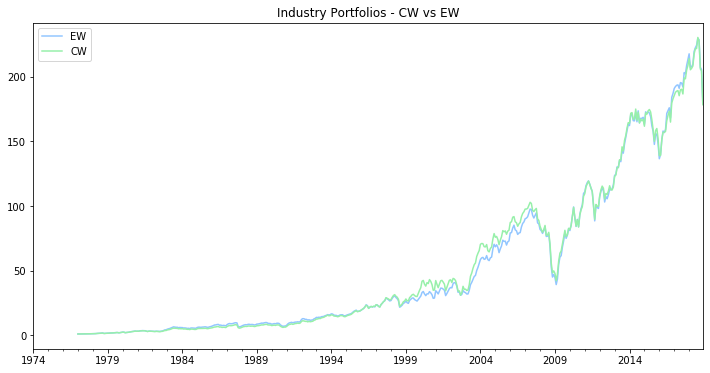

In [34]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

#### Building the Minimum Variance Portfolio

We have previously written the code (from the course 1) to build the minimum variance portfolio 
given the covariance, the **erk.minimize_volatility** method. We will use this method to build the minimum variance portfolio giving in input different covariance matrix estimator.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.527341,-0.589473
GMV-Sample,0.153088,0.116303,-0.811349,6.408442,0.047675,0.072557,1.030012,-0.463917


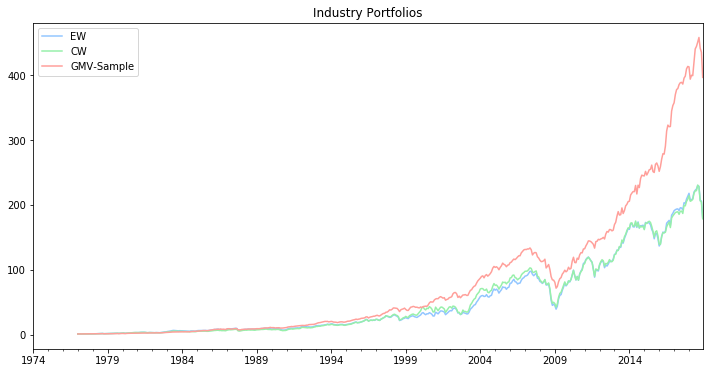

In [35]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

Now, let's try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


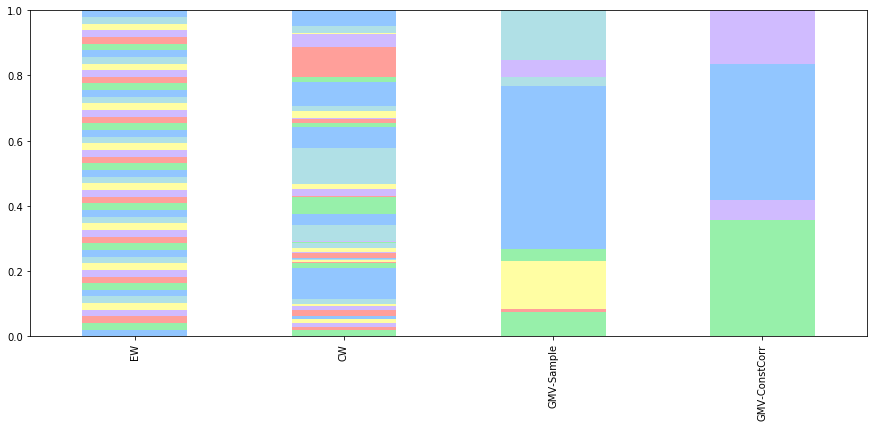

In [36]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2016":]),
    "CW": erk.weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": erk.weight_gmv(ind_rets["2016":], cov_estimator=erk.sample_cov),
    "GMV-ConstCorr": erk.weight_gmv(ind_rets["2016":], cov_estimator=erk.cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.527341,-0.589473
GMV-Sample,0.153088,0.116303,-0.811349,6.408442,0.047675,0.072557,1.030012,-0.463917
GMV-CC,0.132376,0.115348,-0.890954,6.072437,0.049609,0.075268,0.863753,-0.524091


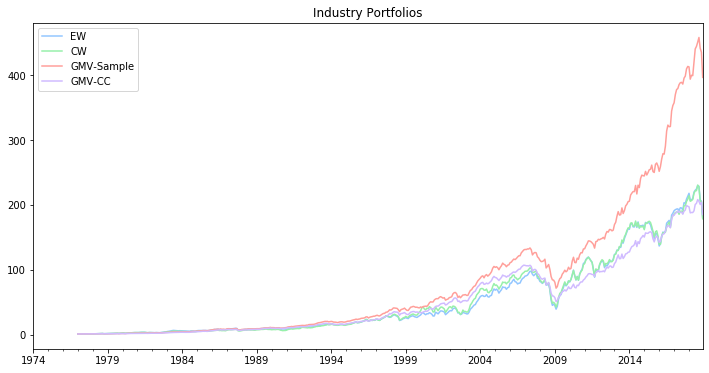

In [37]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$ although in practice many practiotioners choose $0.5$. Let's implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate.

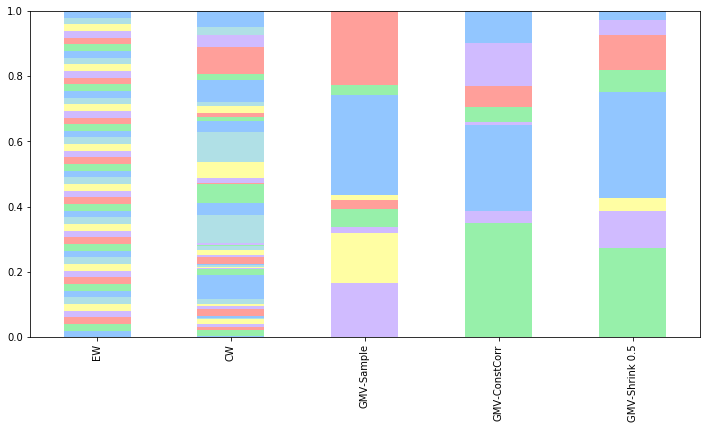

In [38]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2013":]),
    "CW": erk.weight_cw(ind_rets["2013":], cap_weights=ind_mcap),
    "GMV-Sample": erk.weight_gmv(ind_rets["2013":], cov_estimator=erk.sample_cov),
    "GMV-ConstCorr": erk.weight_gmv(ind_rets["2013":], cov_estimator=erk.cc_cov),
    "GMV-Shrink 0.5": erk.weight_gmv(ind_rets["2013":], cov_estimator=erk.shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131382,0.187040,-0.555883,5.825438,0.082040,0.120070,0.527341,-0.589473
GMV-Sample,0.153088,0.116303,-0.811349,6.408442,0.047675,0.072557,1.030012,-0.463917
GMV-CC,0.132376,0.115348,-0.890954,6.072437,0.049609,0.075268,0.863753,-0.524091
GMV-Shrink 0.5,0.138502,0.114873,-0.886389,6.306000,0.048716,0.074239,0.919239,-0.518469


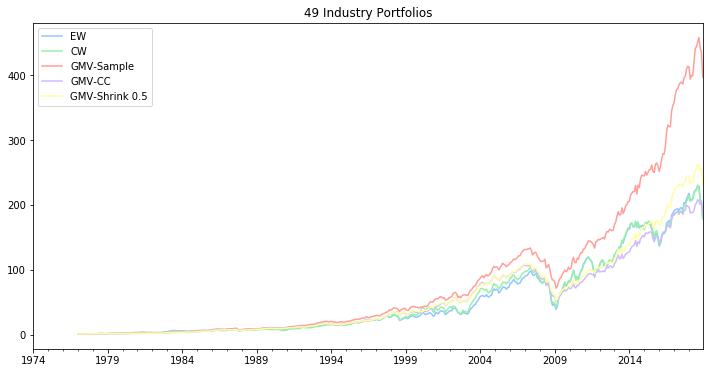

In [39]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_gmv, cov_estimator=erk.shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())